### Data Analyst Agent

In [70]:
# install all libraries in it
%pip install pandas matplotlib seaborn openpyxl pytesseract pillow pdfplumber PyMuPDF together python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [71]:
# Importing Libraries
import os
import io
import pandas as pd
import pytesseract
import fitz  # PyMuPDF
import pdfplumber
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import together
from dotenv import load_dotenv

In [72]:
# Load Together API Key
load_dotenv()
together.api_key = os.getenv("TOGETHER_API_KEY")

In [73]:
# File Reading Functions
def read_csv(file_path):
    return pd.read_csv(file_path)

def read_excel(file_path):
    return pd.read_excel(file_path)

def read_txt(file_path):
    with open(file_path, 'r') as f:
        return f.read()

def read_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

def read_image(file_path):
    img = Image.open(file_path)
    return pytesseract.image_to_string(img)

In [74]:
import time

def query_llama(prompt):
    try:
        client = together.Client()
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
            messages=[
                {"role": "system", "content": "You are a helpful data analyst."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=512,
            top_p=0.7,
            stream=False
        )
        return response.choices[0].message.content
    except Exception as e:
        if "429" in str(e):
            print("Rate limit hit. Waiting for 60 seconds...")
            time.sleep(60)
            return query_llama(prompt)
        return f"[ERROR]: {str(e)}"


In [75]:
print(query_llama("Can you explain what regression analysis is?"))


Regression analysis is a statistical method used to establish a relationship between two or more variables. It's a powerful tool for understanding how a dependent variable (also called the outcome or response variable) is related to one or more independent variables (also called predictors or explanatory variables).

**The Basic Idea**

In regression analysis, we try to create a mathematical model that best predicts the value of the dependent variable based on the values of the independent variables. The goal is to identify the underlying relationships between the variables and to use this information to make predictions or forecasts.

**Key Components**

1. **Dependent Variable (y)**: The variable we're trying to predict or explain.
2. **Independent Variables (x)**: The variables that are used to predict or explain the dependent variable.
3. **Regression Equation**: A mathematical equation that describes the relationship between the dependent variable and the independent variables.

*

In [76]:
# Data Summary & QnA Functions
def get_sample_summary(df):
    return f"Columns: {df.columns.tolist()}\nHead:\n{df.head().to_string()}"

def ask_question_about_data(df, user_question):
    """
    Get concise, professional answers to questions about the data
    """
    # Include more dataset statistics to give the model better context
    stats_summary = ""
    try:
        stats_summary = f"""
Basic statistics for numeric columns:
{df.describe().to_string()}

Dataset shape: {df.shape}
"""
    except:
        pass
        
    # Enhanced prompt with instructions for direct, professional answers
    summary = get_sample_summary(df)
    prompt = f"""You are a professional data analyst responding to executive-level questions. 
Given the following dataset information:

{summary}

{stats_summary}

Respond to this question with a DIRECT and CONCISE answer:
Q: {user_question}

IMPORTANT INSTRUCTIONS:
1. Provide ONLY the final answer without showing calculation steps
2. Be precise and quantitative where appropriate
3. Format numbers professionally (with thousands separators, appropriate decimal places)
4. DO NOT explain your process or methodology 
5. Keep your answer to 1-3 sentences maximum
6. If creating a list, use bullet points
7. If specific data is requested, provide exact values from the dataset
"""
    return query_llama(prompt)

In [77]:
def generate_visualization(df, request):
    """
    Generate visualizations based on user requests.
    
    Args:
        df: pandas DataFrame containing the data
        request: str, user's natural language request for visualization
    
    Returns:
        str: Message indicating what visualization was created
    """
    print("Processing visualization request: " + request)
    
    # First, show what columns are available
    print(f"Available columns: {df.columns.tolist()}")
    
    # Get visualization type and parameters from LLM with improved prompt
    prompt = f"""You are a data visualization expert. Parse the following visualization request and extract exactly:
    1. Plot type (histogram, bar chart, scatter plot, line plot, box plot, heatmap, pie chart)
    2. Column(s) to use - MUST match exactly from the available columns
    3. Any other relevant parameters

    Dataset columns: {df.columns.tolist()}
    Data types: {df.dtypes.to_dict()}
    
    User request: "{request}"
    
    Return ONLY a valid JSON structure without any explanation:
    {{
        "plot_type": "type of plot",
        "columns": ["exact_column_name1", "exact_column_name2"],
        "parameters": {{"param1": "value1"}}
    }}
    
    The columns MUST be from the available columns list and spelled exactly the same.
    Do not include parameters unless explicitly mentioned in the request.
    """
    
    response = query_llama(prompt)
    print(f"LLM response: {response}")
    
    try:
        # Extract JSON-like part from the response with improved pattern matching
        import re
        import json
        
        # Try to find a JSON pattern
        json_match = re.search(r'\{.*\}', response, re.DOTALL)
        
        if json_match:
            json_str = json_match.group(0)
            print(f"Extracted JSON: {json_str}")
            
            # Try to parse the JSON
            try:
                viz_params = json.loads(json_str)
            except json.JSONDecodeError as je:
                # If there's an error, try to clean up the JSON string
                print(f"JSON parse error: {je}. Attempting to clean JSON...")
                # Replace common issues like single quotes with double quotes
                cleaned_json = json_str.replace("'", '"')
                viz_params = json.loads(cleaned_json)
        else:
            return f"Couldn't parse visualization parameters from response. Please try a different request."
            
        plot_type = viz_params.get("plot_type", "").lower()
        columns = viz_params.get("columns", [])
        parameters = viz_params.get("parameters", {})
        
        print(f"Plot type: {plot_type}")
        print(f"Columns: {columns}")
        print(f"Parameters: {parameters}")
        
        # Validate columns
        for col in columns:
            if col not in df.columns:
                return f"Column '{col}' not found in the dataset. Available columns: {df.columns.tolist()}"
        
        # Create the visualization with larger size for better visibility
        plt.figure(figsize=(12, 7))
        
        # Create appropriate visualization
        # Rest of the code remains the same...
        if plot_type == "histogram":
            if len(columns) == 0:
                return "No columns specified for histogram"
            sns.histplot(data=df, x=columns[0], **parameters)
            plt.title(f"Histogram of {columns[0]}")
            
        elif plot_type == "bar chart":
            if len(columns) < 1:
                return "Need at least one column for bar chart"
            x = columns[0]
            y = columns[1] if len(columns) > 1 else None
            
            if y:
                sns.barplot(data=df, x=x, y=y, **parameters)
                plt.title(f"Bar Chart of {y} by {x}")
            else:
                sns.countplot(data=df, x=x, **parameters)
                plt.title(f"Count of {x}")
                
        elif plot_type == "scatter plot":
            if len(columns) < 2:
                return "Need at least two columns for scatter plot"
            x, y = columns[0], columns[1]
            hue = columns[2] if len(columns) > 2 else None
            
            sns.scatterplot(data=df, x=x, y=y, hue=hue, **parameters)
            plt.title(f"Scatter Plot of {y} vs {x}")
            
        elif plot_type == "line plot":
            if len(columns) < 2:
                return "Need at least two columns for line plot"
            x, y = columns[0], columns[1]
            
            sns.lineplot(data=df, x=x, y=y, **parameters)
            plt.title(f"Line Plot of {y} vs {x}")
            
        elif plot_type == "box plot":
            if len(columns) < 1:
                return "Need at least one column for box plot"
            x = columns[0] if len(columns) > 0 else None
            y = columns[1] if len(columns) > 1 else None
            
            sns.boxplot(data=df, x=x, y=y, **parameters)
            if x and y:
                plt.title(f"Box Plot of {y} by {x}")
            else:
                plt.title(f"Box Plot of {x or y}")
                
        elif plot_type == "heatmap":
            if "correlation" in request.lower():
                corr = df.select_dtypes(include=['number']).corr()
                sns.heatmap(corr, annot=True, cmap='coolwarm', **parameters)
                plt.title("Correlation Heatmap")
            else:
                if len(columns) < 2:
                    return "Need at least two columns for heatmap"
                pivot_data = df.pivot_table(index=columns[0], columns=columns[1], 
                                           values=columns[2] if len(columns) > 2 else None, 
                                           aggfunc='mean')
                sns.heatmap(pivot_data, annot=True, cmap='coolwarm', **parameters)
                plt.title(f"Heatmap of {columns}")
                
        elif plot_type == "pie chart":
            if len(columns) < 1:
                return "Need at least one column for pie chart"
            counts = df[columns[0]].value_counts()
            plt.pie(counts, labels=counts.index, autopct='%1.1f%%', **parameters)
            plt.title(f"Pie Chart of {columns[0]}")
            
        else:
            return f"Unsupported plot type: {plot_type}"
        
        plt.tight_layout()
        plt.show()  # This explicitly shows the visualization in Jupyter
        return f"Created {plot_type} for columns: {', '.join(columns)}"
        
    except Exception as e:
        import traceback
        print(f"Error details: {traceback.format_exc()}")
        return f"Error generating visualization: {str(e)}"

In [78]:
def handle_data_request(df, request):
    """
    Process user request about data - either answer questions or create visualizations
    
    Args:
        df: pandas DataFrame containing the data
        request: str, user's natural language request
    
    Returns:
        str: Response to the user's request
    """
    # Determine if this is a visualization request or a question
    prompt = f"""Determine if the following request is asking for:
    1. A visualization/chart/graph/plot
    2. A data question/query/analysis
    
    Request: "{request}"
    
    Answer with just "visualization" or "question":"""
    
    request_type = query_llama(prompt).strip().lower()
    
    if "visual" in request_type or "chart" in request_type or "graph" in request_type or "plot" in request_type:
        return generate_visualization(df, request)
    else:
        return ask_question_about_data(df, request)

In [79]:
# Example Usage
file_path = 'Housing.csv'
ext = file_path.split('.')[-1]

if ext == 'csv':
    df = read_csv(file_path)
elif ext == 'xlsx':
    df = read_excel(file_path)
elif ext == 'txt':
    text = read_txt(file_path)
elif ext == 'pdf':
    text = read_pdf(file_path)
elif ext in ['jpg', 'png']:
    text = read_image(file_path)
else:
    raise Exception("Unsupported file format")

Data Sample:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'g

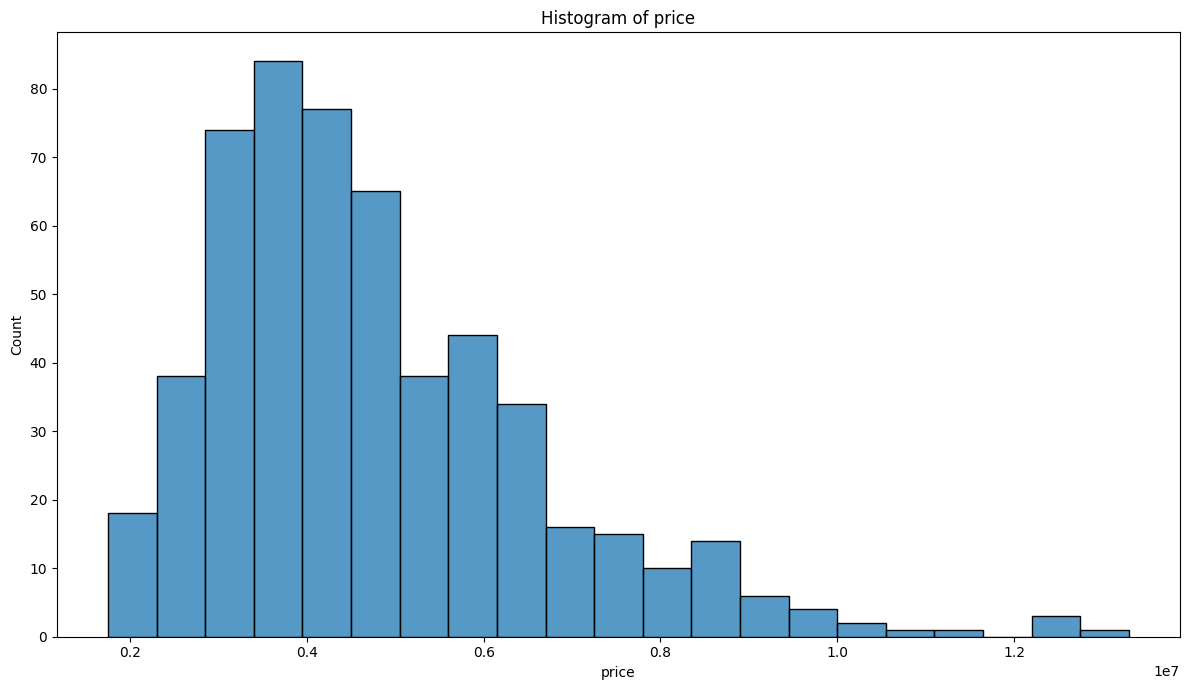

Created histogram for columns: price

Creating bar chart:
Processing visualization request: Create a bar chart showing count of mainroad
Available columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
LLM response: ```json
{
    "plot_type": "bar chart",
    "columns": ["mainroad"],
    "parameters": {}
}
```
Extracted JSON: {
    "plot_type": "bar chart",
    "columns": ["mainroad"],
    "parameters": {}
}
Plot type: bar chart
Columns: ['mainroad']
Parameters: {}


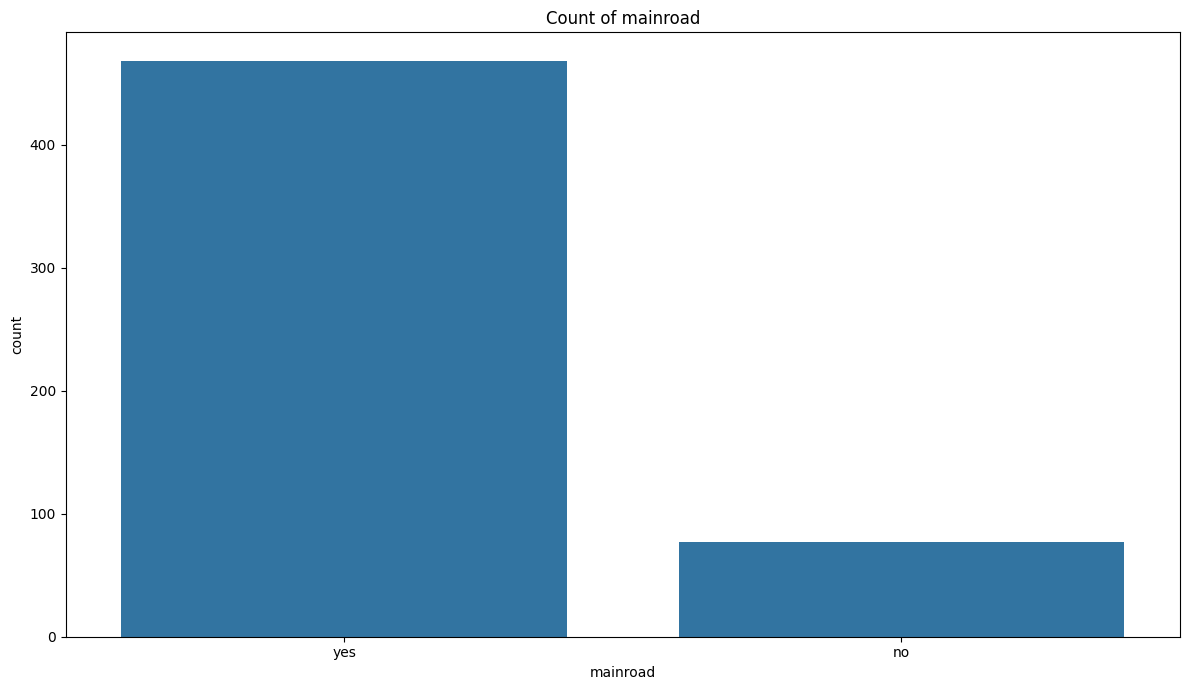

Created bar chart for columns: mainroad

Testing original visualization request:
Processing visualization request: Create a histogram of no of properties and furnishing status
Available columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
Rate limit hit. Waiting for 60 seconds...
LLM response: ```json
{
    "plot_type": "histogram",
    "columns": ["furnishingstatus"],
    "parameters": {}
}
```
Extracted JSON: {
    "plot_type": "histogram",
    "columns": ["furnishingstatus"],
    "parameters": {}
}
Plot type: histogram
Columns: ['furnishingstatus']
Parameters: {}


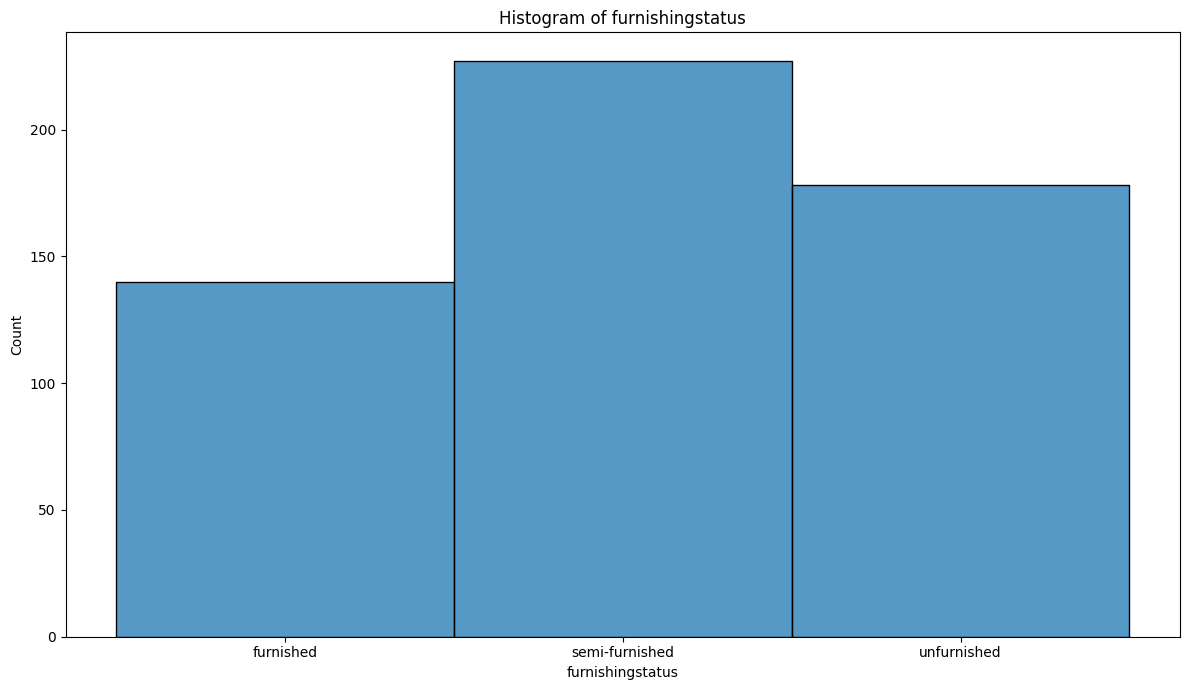

Created histogram for columns: furnishingstatus


In [81]:
# Ask a question about the data (only if it's tabular)
if 'df' in locals():
    print("Data Sample:")
    print(df.head())
    print(f"\nDataset columns: {df.columns.tolist()}")
    
    # Example of asking a question
    question = "What is the average value of the price in this dataset?"
    print("\nAnswer to question:")
    print(handle_data_request(df, question))

    # Example of requesting visualizations
    print("\n--- Testing Visualizations ---")
    
    # Test with a simple histogram first to ensure visualizations work
    print("\nCreating simple histogram:")
    first_numeric_col = df.select_dtypes(include=['number']).columns[0]
    print(generate_visualization(df, f"Create a histogram of {first_numeric_col}"))
    
    # Test a bar chart counting categorical values
    print("\nCreating bar chart:")
    first_categorical_col = df.select_dtypes(include=['object']).columns[0]
    print(generate_visualization(df, f"Create a bar chart showing count of {first_categorical_col}"))
    
    # Now test the user's original request
    print("\nTesting original visualization request:")
    viz_request = "Create a histogram of no of properties and furnishing status"
    print(generate_visualization(df, viz_request))
    
    # Interactive mode for testing - uncomment to use
    # print("\n--- Interactive Mode ---")
    # while True:
    #     user_input = input("\nEnter your visualization request (or 'exit' to quit): ")
    #     if user_input.lower() == 'exit':
    #         break
    #     print(generate_visualization(df, user_input))

elif 'text' in locals():
    prompt = f"You are an assistant. Here is a document:\n{text[:1000]}...\nAnswer a question about it: What is this text about?"
    print(query_llama(prompt))